## Note

- Author: Luke Arunanondchai
- Software: Python 3.7.3, 64-bit

### Overviews
- This script perfrom classification for both sentences and Key Audit Matter section (KAM)) by utilizing and modifying the unsupervised machine learning technique called DBSCAN.

### Steps
1. In the text-preprocessing step, stopwords and unwanted characters are removed. 
2. TFIDF matrix is computed for 1- to 6-gram features corresponding to each tokenized sentences.
3. DBSCAN is performed on the TFIDF matrix. The unique sentences are then separated and go through step 1-3 again in order to generate new sets of featurs before running DBSCAN. The algorithm stops when DBSCAN can no longer reduce the number of unique sentences.
4. Once I have all sentences assigned into groups, I generate a sentence-group-count matrix for all KAM reports. In this matrix, sentence groups serve as features of each KAM report.
5. Then, I perform DBSCAN on the sentence-group-count matrix to classify each KAM report into groups.

### Outputs
1. Report by sentence
2. Report by document
3. Summary Table by Filter
4. Barplots by Filter



### Import the customized package and other external packages

In [1]:
# Import packages 
from KAM_project_4.kam_classification_tools import *
import sklearn
%matplotlib inline 
%matplotlib qt

### Housekeeping Step

In [2]:
# Housekeeping : delete all python objects before starting
for f in glob.glob('..\\Intermediates\\*'):
    os.remove(f)

In [3]:
excel_file = "scraped_textual_data.xlsx"
es_sent = [0.99] ; es_kam = [1.0]

# Choose KAM Item
my_item = 'kam_description'


## KAM Classification Steps

### Perfrom text preprocessing steps and generate the initial output from the 1st step of DBSCAN.

#### Run the following block for the full-sample data

In [4]:
for f in glob.glob('..\\Intermediates\\*'):
    os.remove(f)
    
df_sent = transform_and_train(file = excel_file, my_item = my_item, e = es_sent[0],music=False) 

df_sent_final = seqNoisesClassfication(es_sent[-1],my_item,df_sent,      my_gram = (1,6))
df_sent_final = seqNoisesClassfication(es_sent[-1],my_item,df_sent_final,my_gram = (1,5))
df_sent_final = seqNoisesClassfication(es_sent[-1],my_item,df_sent_final,my_gram = (1,4))
df_sent_final = seqNoisesClassfication(es_sent[-1],my_item,df_sent_final,my_gram = (1,3))
df_sent_final = seqNoisesClassfication(es_sent[-1],my_item,df_sent_final,my_gram = (1,2))
df_sent_final = seqNoisesClassfication(es_sent[-1],my_item,df_sent_final,my_gram = (1,1))
final_kam_group, label_df, orig = kamClassifcation(df_sent_final,my_item,excel_file ,es_kam,output=True)

# print(genSummaryTable(my_item,df_sent_final,final_kam_group,groubp_filer = ['kam_acct_topic'],output=True))

P:\PCAOB Staff\Interns\luke\zoe\Scripts\KAM_project_4\kam_classification_tools.py:197: RuntimeWarning: All-NaN axis encountered
  data.sic_code = data[['sic_code','siccode']].apply(lambda x: np.nanmax(x),axis=1)


Text Preprocessing...
Training...


Done

Iterations corresponding to n-gram = (1, 6)
Number of iterations needed: 2
Number of sentences in the noise group in each iteration: [4346, 4312]
-----------------------------------------------------------------------------------

Iterations corresponding to n-gram = (1, 5)
Number of iterations needed: 3
Number of sentences in the noise group in each iteration: [4312, 4254, 4252]
-----------------------------------------------------------------------------------

Iterations corresponding to n-gram = (1, 4)
Number of iterations needed: 2
Number of sentences in the noise group in each iteration: [4252, 4159]
-----------------------------------------------------------------------------------

Iterations corresponding to n-gram = (1, 3)
Number of iterations needed: 3
Number of sentences in the noise group in each iteration: [4159, 4012, 4008]
-----------------------------------------------------------------------------------

Iterations correspondi

P:\PCAOB Staff\Interns\luke\zoe\Scripts\KAM_project_4\kam_classification_tools.py:416: RuntimeWarning: All-NaN axis encountered
  original_data.sic_code = original_data[['sic_code','siccode']].apply(lambda x: np.nanmax(x),axis=1)



Output Filename:  kam_description_report_1.0_1371.xlsx


### Export the table

In [5]:

paragraph = final_kam_group[['kam_id','text']].copy()
df_sent_para = pd.merge(df_sent_final,paragraph,on="kam_id",how="left")
df_sent_para.rename(columns={'text':'KAM component'},inplace=True)
df_sent_para['word_count_sentence'] = df_sent_para['sentence'].apply(lambda x: len(x.split()))
df_sent_para['word_count_paragraph'] = df_sent_para['KAM component'].apply(lambda x: len(x.split()))



Output Filename:  kam_description_SummaryTable_year.xlsx


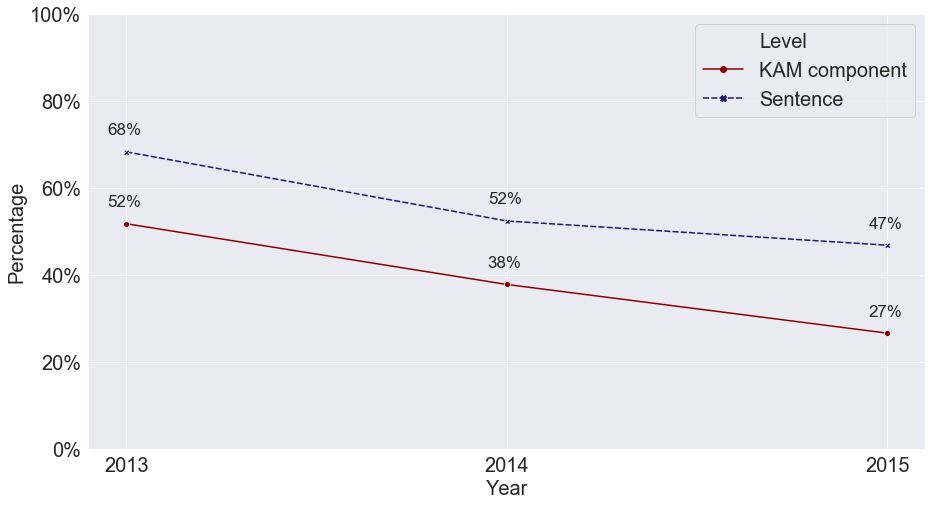

In [63]:
import seaborn as sns
table = genSummaryTable(my_item,df_sent_final,final_kam_group,group_filer = ['year'],output=True).reset_index()
# table.rename(columns={'text':'KAM component'},inplace=True)
table = table[table.Filter.isin([2013,2014,2015])]
table.rename({'Type':'Level'},axis=1,inplace=True)
table.loc[table.Level=='sentence','Level']= 'Sentence'
# table = table[table.Type.isin(['KAM component'])]
table = table.sort_values(by='Level').reset_index(drop=False)
sns.set_style("darkgrid")
my_font_size = 20

if my_item == 'kam_addressing':
    my_palette ={"KAM component":"indianred","Sentence":"dodgerblue"}
else:
    my_palette ={"KAM component":"darkred","Sentence":"midnightblue"}


fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x="Filter", y="Percent", data=table,hue='Level',markers =True,style='Level',palette=my_palette)
ax.set_xticks(range(2013,2016))
ax.set_yticks(range(0,110,20))

ax.tick_params(axis="x", labelsize=my_font_size)
ax.tick_params(axis="y", labelsize=my_font_size)   
ax.set_xlabel('Year',fontsize=my_font_size)
ax.set_ylabel('Percentage',fontsize=my_font_size)

vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(x/100) for x in vals])

for i in range(table.shape[0]):
    if table['Percent'].iloc[i] > 0:
        plt.text(table['Filter'].iloc[i]-0.05, 
                 table['Percent'].iloc[i]+4,  
                 '{:.0%}'.format(table['Percent'].iloc[i]/100), fontsize=my_font_size-3)    

ax.set_title('',fontweight="bold", size=my_font_size)    
    
my_legend =ax.get_legend()
my_legend.set_title('')

plt.setp(my_legend.get_texts(), fontsize=my_font_size) # for legend text
plt.setp(my_legend.get_title(), fontsize=my_font_size) # for legend title
plt.legend(frameon=True, fontsize=my_font_size)
fig.savefig('..\\Outputs\\Figures\\'+my_item+'_lineplots.jpg',bbox_inches='tight')

The plot shows the percentage of all sentences and KAM components that are identified by DBSCAN as similar each year. 
There is a decrease in similarity from 2013 to 2015 among both sentences and components. This result suggests that the language used in KAM reports, in general, is becoming less similar over time, which is considered to be a good thing for investors.
